In [1]:
import dlib, cv2, os
from imutils import face_utils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
detector = dlib.cnn_face_detection_model_v1('dogHeadDetector.dat')
predictor = dlib.shape_predictor('landmarkDetector.dat')

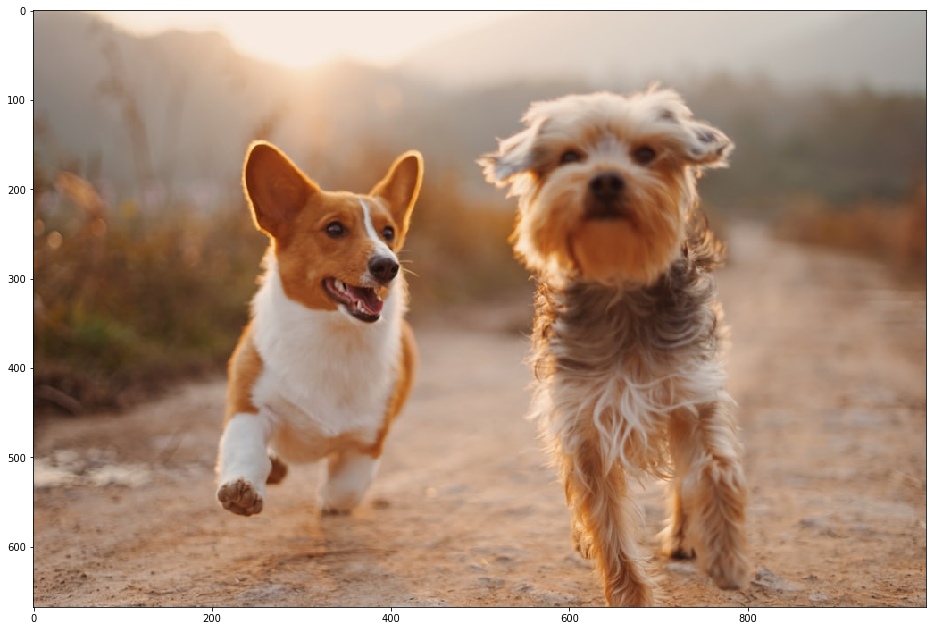

In [9]:
img_path = 'img/dog2.jpg'
filename, ext = os.path.splitext(os.path.basename(img_path))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, dsize=None, fx=0.5, fy=0.5)

plt.figure(figsize=(16, 16))
plt.imshow(img)

Detection 0: Left: 282 Top: 181 Right: 452 Bottom: 351 Confidence: 1.0370590686798096
Detection 1: Left: 529 Top: 81 Right: 733 Bottom: 285 Confidence: 1.0286128520965576


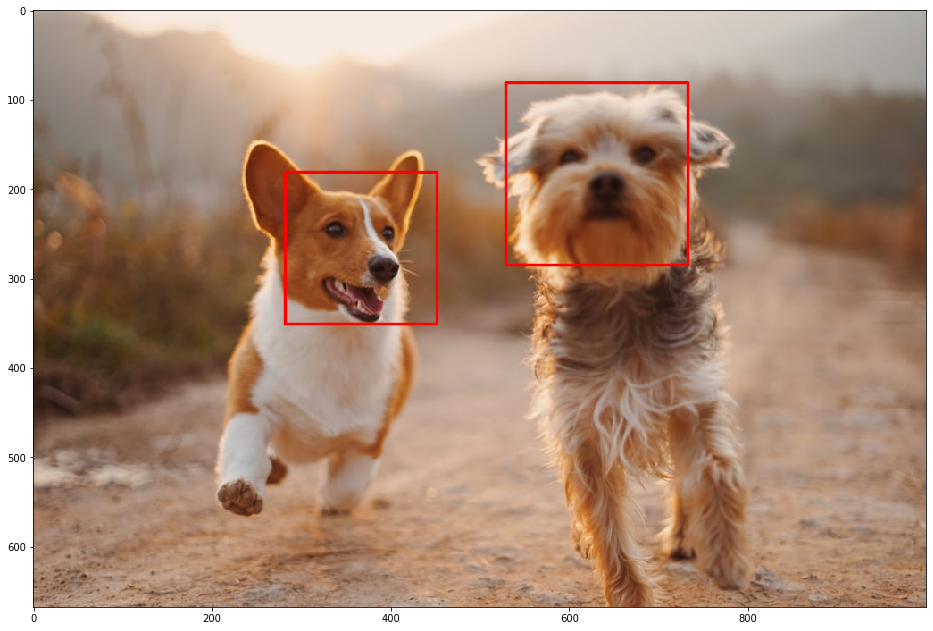

In [10]:
dets = detector(img, upsample_num_times=1)

print(dets)

img_result = img.copy()

for i, d in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} Confidence: {}"
          .format(i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))

    x1, y1 = d.rect.left(), d.rect.top()
    x2, y2 = d.rect.right(), d.rect.bottom()

    cv2.rectangle(img_result, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)
    
plt.figure(figsize=(16, 16))
plt.imshow(img_result)

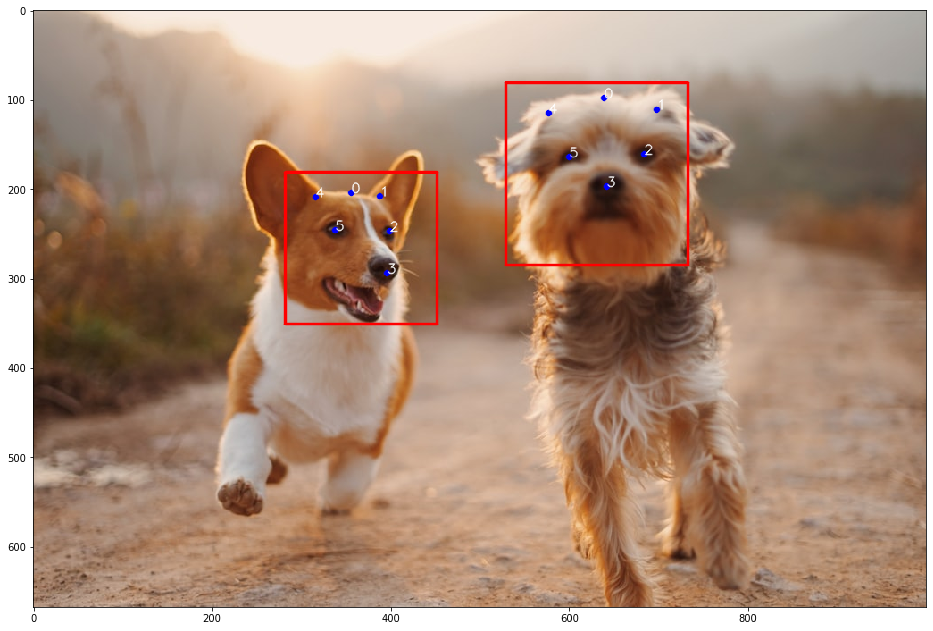

In [11]:
shapes = []

for i, d in enumerate(dets):
    shape = predictor(img, d.rect)
    shape = face_utils.shape_to_np(shape)
    
    for i, p in enumerate(shape):
        shapes.append(shape)
        cv2.circle(img_result, center=tuple(p), radius=3, color=(0,0,255), thickness=-1, lineType=cv2.LINE_AA)
        cv2.putText(img_result, str(i), tuple(p), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

img_out = cv2.cvtColor(img_result, cv2.COLOR_RGB2BGR)
cv2.imwrite('img/%s_out%s' % (filename, ext), img_out)
plt.figure(figsize=(16, 16))
plt.imshow(img_result)

In [12]:
from math import atan2, degrees

# overlay function
def overlay_transparent(background_img, img_to_overlay_t, x, y, overlay_size=None):
    img_to_overlay_t = cv2.cvtColor(img_to_overlay_t, cv2.COLOR_BGRA2RGBA)
    bg_img = background_img.copy()
    # convert 3 channels to 4 channels
    if bg_img.shape[2] == 3:
        bg_img = cv2.cvtColor(bg_img, cv2.COLOR_RGB2RGBA)

    if overlay_size is not None:
        img_to_overlay_t = cv2.resize(img_to_overlay_t.copy(), overlay_size)

    b, g, r, a = cv2.split(img_to_overlay_t)

    mask = cv2.medianBlur(a, 5)

    h, w, _ = img_to_overlay_t.shape
    roi = bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]

    img1_bg = cv2.bitwise_and(roi.copy(), roi.copy(), mask=cv2.bitwise_not(mask))
    img2_fg = cv2.bitwise_and(img_to_overlay_t, img_to_overlay_t, mask=mask)

    bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = cv2.add(img1_bg, img2_fg)

    # convert 4 channels to 4 channels
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_RGBA2RGB)

    return bg_img

def angle_between(p1, p2):
    xDiff = p2[0] - p1[0]
    yDiff = p2[1] - p1[1]
    return degrees(atan2(yDiff, xDiff))

failed overlay image
failed overlay image
failed overlay image
failed overlay image
failed overlay image
failed overlay image


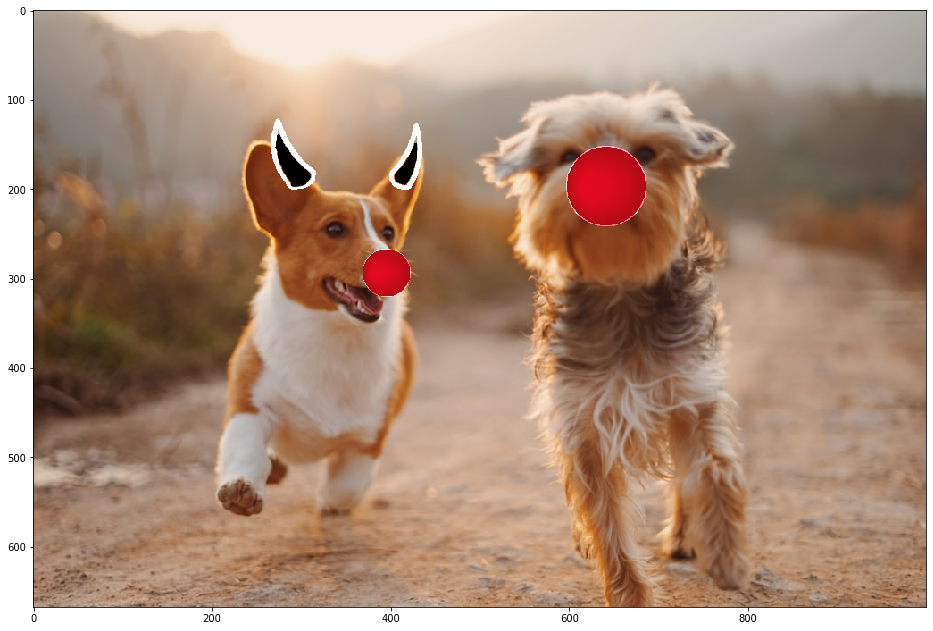

In [19]:
img_result2 = img.copy()

horns = cv2.imread('img/horn2.png',  cv2.IMREAD_UNCHANGED)
horns_h, horns_w = horns.shape[:2]

nose = cv2.imread('img/nose.png',  cv2.IMREAD_UNCHANGED)

for shape in shapes:
    horns_center = np.mean([shape[4], shape[1]], axis=0) // [1, 1.3]
    horns_size = np.linalg.norm(shape[4] - shape[1]) * 3
    
    nose_center = shape[3]
    nose_size = horns_size // 4

    angle = -angle_between(shape[4], shape[1])
    M = cv2.getRotationMatrix2D((horns_w, horns_h), angle, 1)
    rotated_horns = cv2.warpAffine(horns, M, (horns_w, horns_h))

    img_result2 = overlay_transparent(img_result2, nose, nose_center[0], nose_center[1], overlay_size=(int(nose_size), 
                                                                                                       int(nose_size)))
    try:
        img_result2 = overlay_transparent(img_result2, rotated_horns, horns_center[0], horns_center[1], 
                                          overlay_size=(int(horns_size), int(horns_h * horns_size / horns_w)))
    except:
        print('failed overlay image')

img_out2 = cv2.cvtColor(img_result2, cv2.COLOR_RGB2BGR)
cv2.imwrite('img/%s_out2%s' % (filename, ext), img_out2)
plt.figure(figsize=(16, 16))
plt.imshow(img_result2)